# B.4. Equity Options

## Module: FX, Commodities, and Equities

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
# import sys
# sys.path.insert(0, '../cmds')
# from utils import *
# from treasury_cmds import *

import yfinance as yf

In [3]:
TICK = 'MSFT'
msft = yf.Ticker(TICK)

DATE = pd.to_datetime(datetime.date.today())
QDATE = '2022-08-19'

opts = msft.option_chain(QDATE)
calls_raw = opts.calls
puts_raw = opts.puts
px = msft.history('1d')['Close'].values[0]

In [4]:
idx_keep = list()
for idx in calls_raw.index:
    days_traded = (calls_raw.loc[idx,'lastTradeDate'].tz_localize(None) - DATE).total_seconds()/(24*60*60)
    if days_traded > -1:
        idx_keep.append(idx)

calls = calls_raw.loc[idx_keep,:]

idx_keep = list()
for idx in puts_raw.index:
    days_traded = (puts_raw.loc[idx,'lastTradeDate'].tz_localize(None) - DATE).total_seconds()/(24*60*60)
    if days_traded > -1:
        idx_keep.append(idx)

puts = puts_raw.loc[idx_keep,:]

# Equity Options

## Call option

A **call option** on an asset gives the holder of the call the right, but not the obligation, to buy the **underlying** asset at a pre-specified price.
- The call option must be purchased from a counterparty willing to *write* the call.
- The price paid to buy the call is the **premium**.
- Note the difference from forwards and swaps, which have no cost at initiation. The call option clearly has value at initialization, given that it is an option without obligation.

### Strike
The **strike price** (also known as the **exercise price**,) is the agreed price at which the call holder can buy the asset.
- Note that the strike is a parameter of the contract--it is certain.
- The strike is the future cost, (paid at exercise,) not a present value. 

If the security underlying the call has a price above the strike price, it is said to be **in the money**.

## Put option

A **put option** on an asset gives the holder of the put the right, but not the obligation, to *sell* the **underlying** asset at a pre-specified price.

In [5]:
idCall = calls['strike'].sub(px).abs().idxmin()
K = calls.loc[idCall,:]['strike']
expry = QDATE

grid_px = np.arange(px/1.5,px*(4/3),.1)

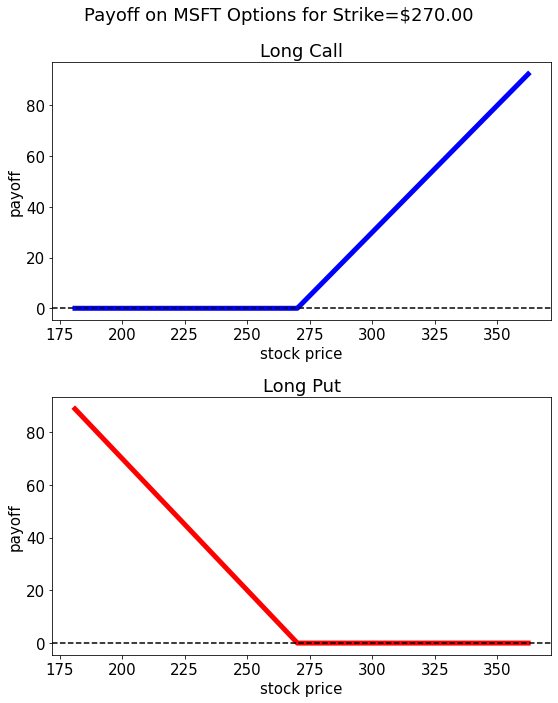

In [6]:
fig,ax = plt.subplots(2,figsize=(8,10))
ex_call = pd.Series(index=grid_px,data=[max(px-K,0) for px in grid_px])
ex_call.plot(ax=ax[0],title='Long Call',xlabel='stock price',ylabel='payoff',linewidth=5,color='b')
ex_put = pd.Series(index=grid_px,data=[max(K-px,0) for px in grid_px])
ex_put.plot(ax=ax[1],title='Long Put',xlabel='stock price',ylabel='payoff',linewidth=5,color='r')
ax[0].axhline(0,color='k',linestyle='--')
ax[1].axhline(0,color='k',linestyle='--')

plt.suptitle(f'Payoff on {TICK} Options for Strike=${K:,.2f}')
plt.tight_layout()
plt.show()

### Expiration
The call option has an **expiration** date. 

Most traded equity options have short-term expirations--weeks or a few months.


### Style
Consider two *styles* of options,

**European**: stipulates that the option can only be exercised at the expiration date.
- Useful starting point for considering the pricing and risk of equity options.
- In practice, more common to see European style for stock index options and foreign currency options.

**American**: allows the option to be exercised any time up to the expiration date.
- Most equity options traded in the U.S. are American style.
- Do not have closed-form solutions, so require numerical methods.

**Other styles**
- Not our focus, but will see so-called *Bermudan*, *Asian*, etc.

These labels have nothing to do with *where* the options trade.



## Value

Consider how the following features impact the value of the call and put.

Consider whether each cell of the table should have a "+" or "-".

|                  | call | put |
|------------------|------|-----|
| american style   |      |     |
| strike           |      |     |
| expiration       |      |     |
| stock volatility |      |     |
| interest rate    |      |     |
| stock dividend   |      |     |


### A long put is NOT a short call
A put option is not the same as selling, or writing, a call option.
- The **buyer of a put option** has 
    - *limited upside*: The underlying price can only go to zero
    - *limited downside*: Losing the premium if the option stays out of the money.
    
- The **seller of a call** has 
    - *unlimited downside*: The underlying asset can appreciate without limit
    - *limited upside*: The premium gained by writing the call.

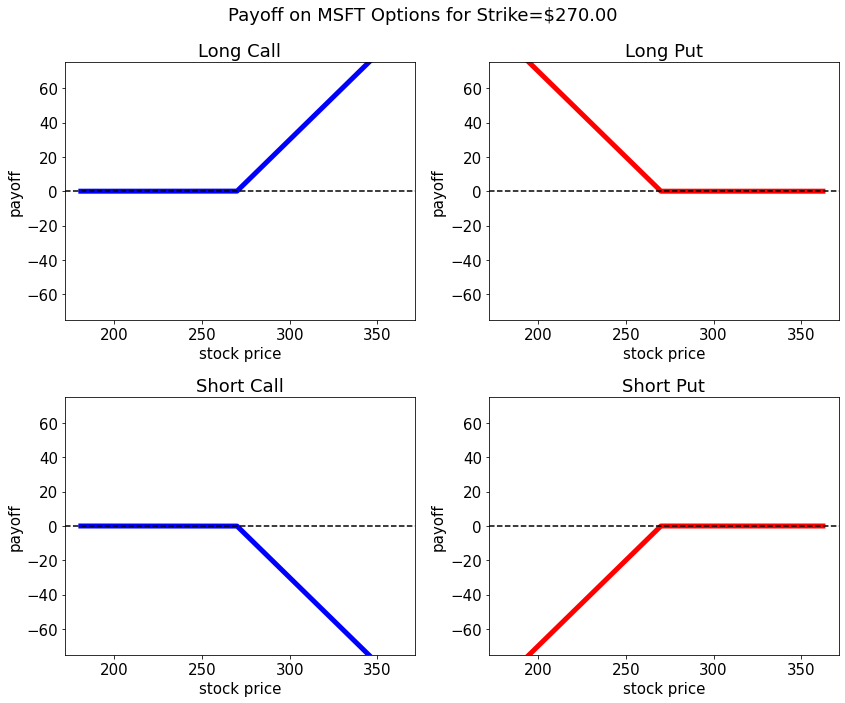

In [7]:
yb = 75

fig,ax = plt.subplots(2,2,figsize=(12,10))
ex_call.plot(ax=ax[0,0],title='Long Call',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='b')
ex_put.plot(ax=ax[0,1],title='Long Put',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='r')
(-ex_call).plot(ax=ax[1,0],title='Short Call',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='b')
(-ex_put).plot(ax=ax[1,1],title='Short Put',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='r')

ax[0,0].axhline(0,color='k',linestyle='--')
ax[0,1].axhline(0,color='k',linestyle='--')
ax[1,0].axhline(0,color='k',linestyle='--')
ax[1,1].axhline(0,color='k',linestyle='--')

plt.suptitle(f'Payoff on {TICK} Options for Strike=${K:,.2f}')
plt.tight_layout()
plt.show()

### Option price as a function of strike

Notice that the relationship is nonlinear.
- The payoff function is (piecewise) linear in strike
- Yet the pricing function is nonlinear--particularly when the underlyling stock price is near the strike price.

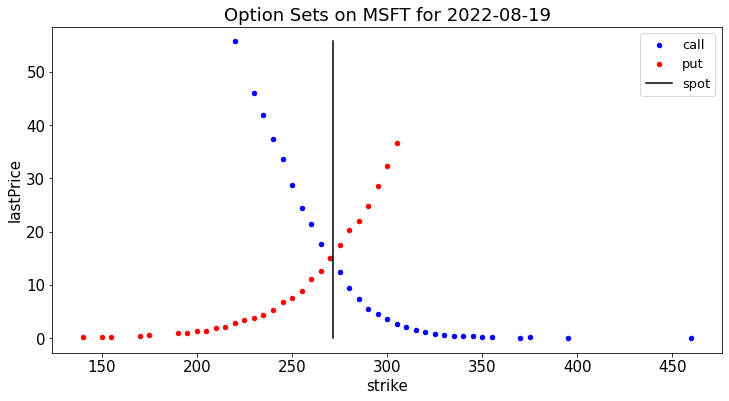

In [8]:
ax = calls[['strike','lastPrice']].plot.scatter(x='strike',y='lastPrice',color='b')
puts[['strike','lastPrice']].plot.scatter(ax=ax, x='strike',y='lastPrice',color='r')

grid_min = max(calls['lastPrice'].min(),calls['lastPrice'].min())
grid_max = max(calls['lastPrice'].max(),calls['lastPrice'].max())
grid_plot_spot = pd.Series(data=[grid_min,grid_max],index=[px,px]).T
grid_plot_spot.plot(ax=ax,color='k')

plt.legend(['call','put','spot'])
plt.title(f'Option Sets on {TICK} for {QDATE}')

plt.show()

### Option price as a function of expiration

The option price is increasing in the time-to-expiration.

In [9]:
dts = ['2022-07-15','2022-07-22','2022-08-19','2022-09-16','2022-10-21','2022-11-18','2022-12-16']

pquote = pd.DataFrame(index=dts,columns=['call','put'],dtype=float)
for dt in dts:
    temp = msft.option_chain(dt).calls
    pquote.loc[dt,'call'] = temp[temp['strike']==K]['lastPrice'].values[0]
    
    temp = msft.option_chain(dt).puts
    pquote.loc[dt,'put'] = temp[temp['strike']==K]['lastPrice'].values[0]

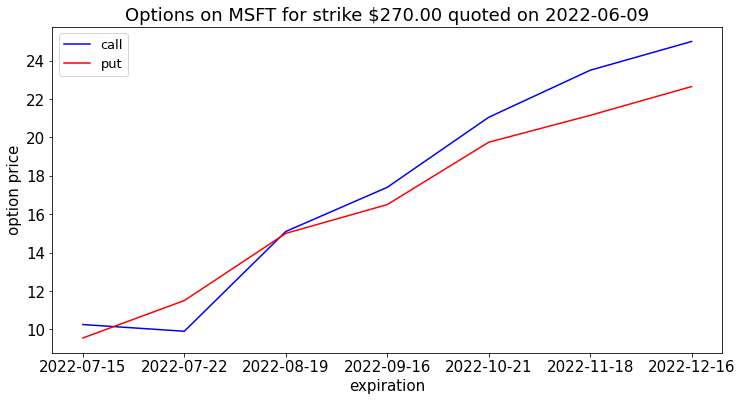

In [10]:
pquote.plot(xlabel='expiration',ylabel='option price',color=['b','r'])
plt.title(f'Options on {TICK} for strike ${K:,.2f} quoted on {DATE:%Y-%m-%d}')
plt.show()

# Put-Call Parity

## Key result

Calls and puts are closely related. Two equivalent ways to think about it...

## Replication

Replicate a share of stock with...
- long call
- short put
- long cash (a zero coupon bond with face value equal to strike)

This will have the same payoff as the share of stock in every situation.

See the payoff graphs to see this conceptually.

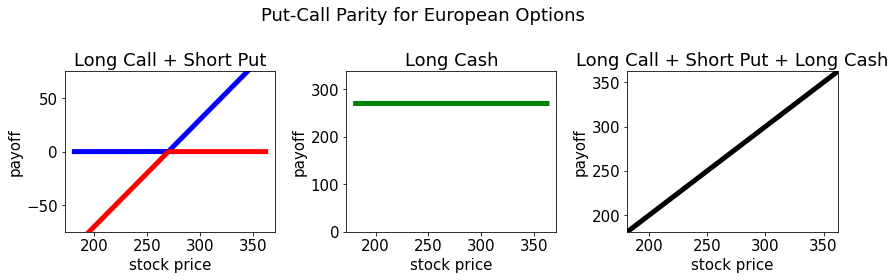

In [16]:
yb = 75

grid_K = pd.Series(index=ex_call.index,data=K)

fig,ax = plt.subplots(1,3,figsize=(12,4))

ex_call.plot(ax=ax[0],linewidth=5,color='b')
(-ex_put).plot(ax=ax[0],linewidth=5,color='r')

#ax[0].axhline(0,color='m',linewidth=6)
ax[0].set_title('Long Call + Short Put')
ax[0].set_ylabel('payoff')
ax[0].set_xlabel('stock price')
ax[0].set_ylim(-yb,yb)

(grid_K).plot(ax=ax[1],linewidth=5,color='g')
ax[1].set_title('Long Cash')
ax[1].set_ylabel('payoff')
ax[1].set_xlabel('stock price')
ax[1].set_ylim(0,K*1.25)

(ex_call-ex_put+grid_K).plot(ax=ax[2],linewidth=5,color='k')
ax[2].set_title('Long Call + Short Put + Long Cash')
ax[2].set_ylabel('payoff')
ax[2].set_xlabel('stock price')
ax[2].set_ylim(grid_px[0],grid_px[-1])
ax[2].set_xlim(grid_px[0],grid_px[-1])

plt.suptitle(f'Put-Call Parity for European Options')
plt.tight_layout()
plt.show()

### No-arbitrage

If the payoffs are equal at $T$, then they must have the same price today, via no-arbitrage.

### The mathematical formula

Notation
- $c$: price of a European call
- $p$: price European put
- $K$: strike price of both the put and call
- $S_o$: price of stock at time of valuation
- $r$: continuously compounded risk-free interest rate
- $T$: time until expiration (in years)

$\begin{align}
c + Ke^{-rT} = p + S_0
\end{align}$

### Implications

Put-call parity is among the most important results in options pricing.

1. Puts and calls must be priced in one consistent model, not as separate securities.

1. The call-put spread equals the *moneyness* of the option:

$$c-p = S_0 - Ke^{-rT}$$

- this has implications for option strategies that require going long calls and short puts, or vice-versa.
- if a stock is equal to the strike (*at the money*) then the call is slightly more valuable than the put. 

# Black Scholes

# Appendix: Size of Markets

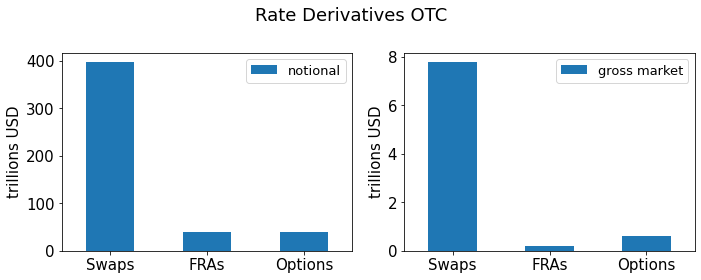

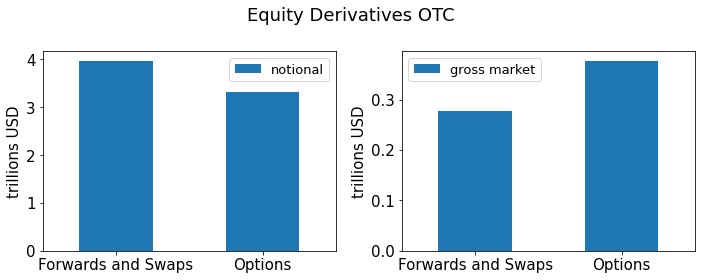

In [13]:
bis_rates = pd.DataFrame(index=['Swaps','FRAs','Options'],data=[397109,39438,38562],columns=['notional'])
bis_rates['gross market'] = [7787,195,630]
bis_eqty = pd.DataFrame(index=['Forwards and Swaps','Options'],data=[3968,3312],columns=['notional'])
bis_eqty['gross market'] = [278,377]

bis_rates /= 1000
bis_eqty /= 1000

fig,ax = plt.subplots(1,2,figsize=(10,4))
bis_rates[['notional']].plot.bar(ax=ax[0],ylabel='trillions USD')
bis_rates[['gross market']].plot.bar(ax=ax[1],ylabel='trillions USD')

ax[0].tick_params(axis='x',rotation=0)
ax[1].tick_params(axis='x',rotation=0)

plt.suptitle('Rate Derivatives OTC')
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
bis_eqty[['notional']].plot.bar(ax=ax[0],ylabel='trillions USD')
bis_eqty[['gross market']].plot.bar(ax=ax[1],ylabel='trillions USD')

ax[0].tick_params(axis='x',rotation=0)
ax[1].tick_params(axis='x',rotation=0)

plt.suptitle('Equity Derivatives OTC')
plt.tight_layout()
plt.show()

Reference: CBOE

https://www.cboe.com/us/options/market_statistics/#current

Reference: Bank of International Settlements

https://stats.bis.org/statx/srs/table/d5.1